In [1]:
#pipeleine:
# integrated with nepetune.ai
# testing boostnig and trees algorithms\
# droping uneusful features


#used frgmenst of code:  https://machinelearningmastery.com/gradient-boosting-with-scikit-learn-xgboost-lightgbm-and-catboost/
#My  notebook based on notebook "pipeline2"  - Author:Salem Albarudy
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import pandas as pd
import os
import time
from tqdm import tqdm

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()


# Ignore useless warnings (see SciPy issue #5998)
# import warnings
# warnings.filterwarnings(action="ignore", message="^internal gelsd")


# ...
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
# from sklearn.model_selection import train_test_split

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import LabelEncoder
# from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

import xgboost as xgb

from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.svm import NuSVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# from sklearn import metrics

from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, accuracy_score, roc_curve, roc_auc_score
from sklearn.metrics import plot_confusion_matrix


# import category_encoders as ce
# from category_encoders import BinaryEncoder

In [38]:
import neptune

API_TOKEN='Yoyr TOKEN=' #@param {type:"string"}

PROJEKT_NAME = 'DataWorkshop-Foundation/Predicting-cancellation-of-visit' 

neptune.init(
    api_token=API_TOKEN,
    project_qualified_name=PROJEKT_NAME
)

Project(DataWorkshop-Foundation/Predicting-cancellation-of-visit)

In [3]:
# Paths ...
PATH_TO_DATA_DIR = os.path.join('..', 'input')

# ...
ADASYN_DATASET_TRAIN = os.path.join(PATH_TO_DATA_DIR, 'Adasyn_train.csv')
ADASYN_DATASET_TEST = os.path.join(PATH_TO_DATA_DIR, 'Adasyn_test.csv')

NEARMISS_DATASET_TRAIN = os.path.join(PATH_TO_DATA_DIR, 'Nearmiss_train.csv')
NEARMISS_DATASET_TEST = os.path.join(PATH_TO_DATA_DIR, 'Nearmiss_test.csv')


SMOTE_TOMEK_DATASET_TRAIN = os.path.join(PATH_TO_DATA_DIR, 'SMOTETomek_train.csv')
SMOTE_TOMEK_DATASET_TEST = os.path.join(PATH_TO_DATA_DIR, 'SMOTETomek_test.csv')

RAW_DATASET_TRAIN = os.path.join(PATH_TO_DATA_DIR, 'Raw_train.csv')
RAW_DATASET_TEST = os.path.join(PATH_TO_DATA_DIR, 'Raw_test.csv')

PATH_TO_DATA_DIR

'..\\input'

In [4]:
#models
classifiers = [
    LogisticRegression(),
    HistGradientBoostingClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    CatBoostClassifier(),
    ExtraTreesClassifier(),
    xgb.XGBClassifier(),
    LGBMClassifier(),
]

## Model Selector

In [35]:
def plot_hist(dataFrame, feature, title='Histogram'):
    sns.set(style="ticks", color_codes=True)
    sns.distplot(dataFrame[feature], color='red', kde=False, bins=5)

    plt.title(title)
    plt.xlim(-0.5, 1.5)
    plt.tight_layout();

    # plt.savefig('./imgs/barplot_price_bin.png', dpi=300);

    
def split_data_set(df_train_, df_test_):
    print(df_train_.shape)
    print(df_test_.shape)
    # droping uneusful features  -  fragment code from notebook:
    # Features_selection_Logistic_Regression_&_RandomSearch_&_GridSearch_Dominik_Stepien.ipynb
    all_features =list((df_train_.loc[:, df_train_.columns != 'NoShow']).columns)
    drop_features=['NoShow','MonthAppointmentDate_0', 'AppointmentWeekDay_0','AppointmentWeekDay_0','HourOfDayBooking_0', 'DayAppointmentDate_0','MonthBookingDate_0','Neighbourhood_0','DayBookingDate_0',]
    features = [ item for item in all_features if item not in drop_features]
   
    X_test_ = df_test_[features]
    
#   X_train_ = df_train_.loc[:, df_train_.columns != 'NoShow'] 
    X_train_ =  df_train_[features]
    y_train_ = df_train_[['NoShow']].values

#     X_test_ = df_test_.loc[:, df_test_.columns != 'NoShow'] 
    y_test_ = df_test_[['NoShow']].values
    X_test_ = df_test_[features]
    return X_train_, y_train_, X_test_, y_test_

class ModelSelector:
    def __init__(self, dataset):
        self.X_train, self.y_train, self.X_test, self.y_test = dataset
        #self.X_train = X_train
        #self.y_train = y_train
        #self.X_test = X_test
        #self.y_test = y_test

    def __get_processing_full_pipeline(self):
        # ...
        numeric_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ])
        # ...
        categorical_transformer = None

        # ...
        return FeatureUnion(transformer_list=[
            ("num_pipeline", numeric_transformer),
#             ("cat_pipeline", categorical_transformer),
        ])


    def __get_pipline(self, classifier):
        return Pipeline(steps = [
                ('processing_full_pipeline', self.__get_processing_full_pipeline()),
                ('classifier', classifier)
            ]
        )

    def __make_plots(self, pipe):
        
        plot_confusion_matrix(
            pipe, 
            self.X_test,
            self.y_test,
            cmap="BuGn",
            normalize='true',
            #ax=ax6
        );
        print('='*50)

    def start(self, classifiers):
        print('===================  START  ===================')
        df_models_performence = []
        for classifier in classifiers:
            print('START ', type(classifier).__name__)
            pipe = self.__get_pipline(classifier)
            pipe.fit(self.X_train, self.y_train)
            
            # ...
            y_pred_ = pipe.predict(self.X_test)
            train_score = pipe.score(self.X_train, self.y_train)
            test_score = pipe.score(self.X_test, self.y_test)
            accuracy_score_ = round(accuracy_score(self.y_test, y_pred_), 3)
            precision_score_ = round(precision_score(self.y_test, y_pred_), 3)
            recall_score_ = round(recall_score(self.y_test, y_pred_), 3)
            f1_score_ = round(f1_score(self.y_test, y_pred_), 3)
            roc_auc_score_ =  round(roc_auc_score(self.y_test, y_pred_), 3)

            # ...
            df_models_performence.append({
                'name': type(classifier).__name__,
                'train_score': train_score,
                'test_score': test_score,
                'accuracy_score': accuracy_score_,
                'precision_score': precision_score_,
                'recall_score': recall_score_,
                'f1_score': f1_score_,
                'roc_auc_score': roc_auc_score_,
            })

                        ######neptun START######
                
            neptune.create_experiment()
#           name=name
                  

            neptune.log_metric('accuracy', accuracy_score_)
            neptune.log_metric('f1', f1_score_)
            neptune.log_metric('recall', recall_score_)
            neptune.log_metric('precision', precision_score_)
            neptune.log_metric('roc_auc', roc_auc_score_)
            neptune.append_tags([str(classifier),'RAW','pipeline2','Dominik Stępień'])
            
            neptune.stop()
                
                        ######neptun STOP######
                    
                    
            self.__make_plots(pipe)
            print('END ', type(classifier).__name__)
                

        print('===================  END  ===================')
        return pd.DataFrame(df_models_performence)

## Adasyn

In [22]:
adasyn_dataset = split_data_set(
    pd.read_csv(ADASYN_DATASET_TRAIN),
    pd.read_csv(ADASYN_DATASET_TEST)
)

(123381, 43)
(34937, 43)


===================  START  ===================
START  LogisticRegression


C:\Users\domin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


END  LogisticRegression
START  LogisticRegression


C:\Users\domin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


END  LogisticRegression
START  HistGradientBoostingClassifier


C:\Users\domin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


END  HistGradientBoostingClassifier
START  DecisionTreeClassifier
END  DecisionTreeClassifier
START  RandomForestClassifier


C:\Users\domin\Anaconda3\lib\site-packages\sklearn\pipeline.py:335: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


END  RandomForestClassifier
START  AdaBoostClassifier


C:\Users\domin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


END  AdaBoostClassifier
START  GradientBoostingClassifier


C:\Users\domin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


END  GradientBoostingClassifier
START  CatBoostClassifier
Learning rate set to 0.080519
0:	learn: 0.6563760	total: 51.7ms	remaining: 51.7s
1:	learn: 0.6226381	total: 120ms	remaining: 59.9s
2:	learn: 0.5969791	total: 155ms	remaining: 51.5s
3:	learn: 0.5419852	total: 185ms	remaining: 46s
4:	learn: 0.5074591	total: 221ms	remaining: 43.9s
5:	learn: 0.4938388	total: 259ms	remaining: 43s
6:	learn: 0.4836662	total: 300ms	remaining: 42.5s
7:	learn: 0.4741887	total: 343ms	remaining: 42.5s
8:	learn: 0.4632277	total: 390ms	remaining: 42.9s
9:	learn: 0.4560420	total: 419ms	remaining: 41.5s
10:	learn: 0.4487992	total: 460ms	remaining: 41.3s
11:	learn: 0.4304984	total: 509ms	remaining: 41.9s
12:	learn: 0.4222198	total: 549ms	remaining: 41.7s
13:	learn: 0.4181150	total: 601ms	remaining: 42.3s
14:	learn: 0.4142093	total: 642ms	remaining: 42.2s
15:	learn: 0.4100564	total: 680ms	remaining: 41.9s
16:	learn: 0.4063998	total: 719ms	remaining: 41.6s
17:	learn: 0.4030707	total: 745ms	remaining: 40.6s
18:	lea

C:\Users\domin\Anaconda3\lib\site-packages\sklearn\pipeline.py:335: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


END  ExtraTreesClassifier
START  XGBClassifier


C:\Users\domin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


END  XGBClassifier
START  LGBMClassifier


C:\Users\domin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


END  LGBMClassifier
===================  END  ===================


,name,train_score,test_score,accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
0,LogisticRegression,0.818538,0.820076,0.820,0.850,0.778,0.812,0.820
1,LogisticRegression,0.818538,0.820076,0.820,0.850,0.778,0.812,0.820
2,HistGradientBoostingClassifier,0.859695,0.857544,0.858,0.944,0.760,0.842,0.858
3,DecisionTreeClassifier,0.998436,0.803389,0.803,0.806,0.799,0.802,0.803
4,RandomForestClassifier,0.998403,0.859032,0.859,0.915,0.791,0.849,0.859
5,AdaBoostClassifier,0.812329,0.813836,0.814,0.811,0.819,0.815,0.814
6,GradientBoostingClassifier,0.840559,0.840942,0.841,0.887,0.781,0.831,0.841
7,CatBoostClassifier,0.500323,0.499982,0.860,0.937,0.773,0.847,0.860
8,ExtraTreesClassifier,0.998436,0.848899,0.849,0.887,0.799,0.841,0.849
9,XGBClassifier,0.879706,0.854080,0.854,0.922,0.773,0.841,0.854


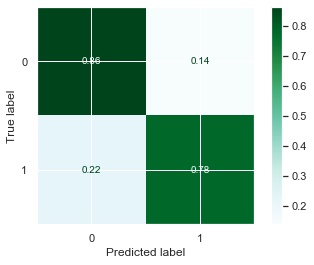

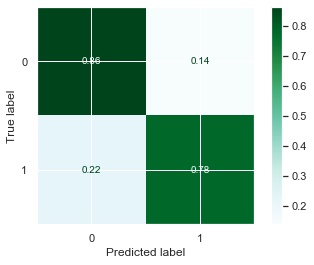

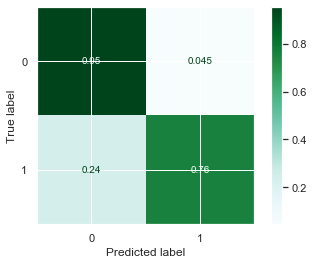

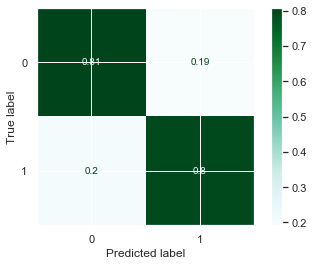

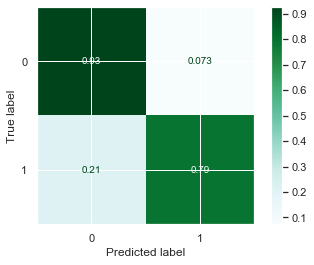

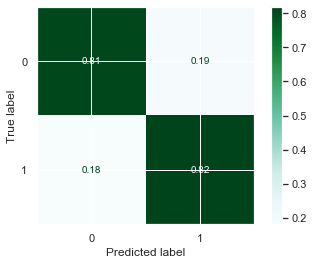

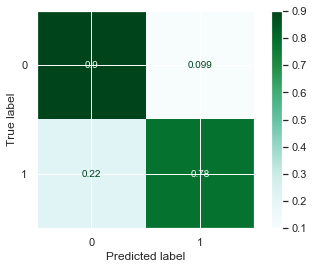

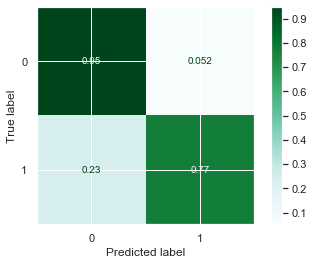

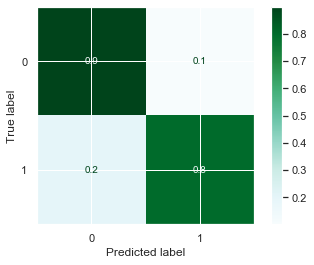

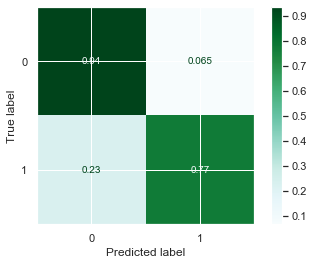

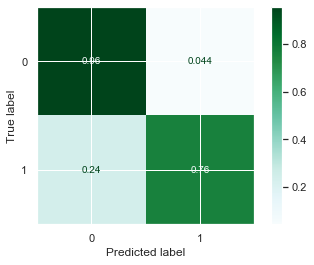

In [23]:
model_selector_adasyn = ModelSelector(adasyn_dataset)
df_ = model_selector_adasyn.start(classifiers)
df_

In [58]:
df_

,name,train_score,test_score,precision_score,recall_score,f1_score
0,LogisticRegression,0.818538,0.820076,0.850,0.778,0.812
1,DecisionTreeClassifier,0.998436,0.801471,0.804,0.798,0.801
2,RandomForestClassifier,0.998420,0.859891,0.916,0.792,0.850
3,AdaBoostClassifier,0.812329,0.813836,0.811,0.819,0.815
4,GradientBoostingClassifier,0.840559,0.840942,0.887,0.781,0.831
5,CatBoostClassifier,0.500323,0.499982,0.937,0.773,0.847
6,ExtraTreesClassifier,0.998436,0.848613,0.886,0.800,0.841
7,XGBClassifier,0.879706,0.854080,0.922,0.773,0.841


## Nearmiss

In [27]:
nearmiss_dataset = split_data_set(
    pd.read_csv(NEARMISS_DATASET_TRAIN),
    pd.read_csv(NEARMISS_DATASET_TEST)
)

(31328, 43)
(8836, 43)


===================  START  ===================
START  LogisticRegression


C:\Users\domin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
NVMLError: NVML Shared Library Not Found - GPU usage metrics may not be reported.


https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-249
END  LogisticRegression
START  LogisticRegression


C:\Users\domin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-250
END  LogisticRegression
START  HistGradientBoostingClassifier


C:\Users\domin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-251
END  HistGradientBoostingClassifier
START  DecisionTreeClassifier
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-252
END  DecisionTreeClassifier
START  RandomForestClassifier


C:\Users\domin\Anaconda3\lib\site-packages\sklearn\pipeline.py:335: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
NVMLError: NVML Shared Library Not Found - GPU usage metrics may not be reported.


https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-253
END  RandomForestClassifier
START  AdaBoostClassifier


C:\Users\domin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-254
END  AdaBoostClassifier
START  GradientBoostingClassifier


C:\Users\domin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-255
END  GradientBoostingClassifier
START  CatBoostClassifier
Learning rate set to 0.044843
0:	learn: 0.6663988	total: 44.4ms	remaining: 44.4s
1:	learn: 0.6441574	total: 67.1ms	remaining: 33.5s
2:	learn: 0.6232225	total: 81ms	remaining: 26.9s
3:	learn: 0.6050573	total: 92.2ms	remaining: 23s
4:	learn: 0.5887022	total: 105ms	remaining: 20.8s
5:	learn: 0.5742178	total: 138ms	remaining: 22.8s
6:	learn: 0.5612852	total: 154ms	remaining: 21.8s
7:	learn: 0.5492415	total: 171ms	remaining: 21.2s
8:	learn: 0.5396880	total: 186ms	remaining: 20.5s
9:	learn: 0.5316834	total: 207ms	remaining: 20.5s
10:	learn: 0.5231022	total: 223ms	remaining: 20.1s
11:	learn: 0.5166688	total: 237ms	remaining: 19.5s
12:	learn: 0.5108726	total: 249ms	remaining: 18.9s
13:	learn: 0.5045607	total: 260ms	remaining: 18.3s
14:	learn: 0.4994558	total: 272ms	remaining: 17.8s
15:	learn: 0.4944742	total: 285ms	remaining: 17.5s
16:	learn: 0.4898

NVMLError: NVML Shared Library Not Found - GPU usage metrics may not be reported.


https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-256
END  CatBoostClassifier
START  ExtraTreesClassifier


C:\Users\domin\Anaconda3\lib\site-packages\sklearn\pipeline.py:335: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-257
END  ExtraTreesClassifier
START  XGBClassifier


C:\Users\domin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-258
END  XGBClassifier
START  LGBMClassifier


C:\Users\domin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-259
END  LGBMClassifier
===================  END  ===================


,name,train_score,test_score,accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
0,LogisticRegression,0.702343,0.701335,0.701,0.750,0.604,0.669,0.701
1,LogisticRegression,0.702343,0.701335,0.701,0.750,0.604,0.669,0.701
2,HistGradientBoostingClassifier,0.802892,0.800136,0.800,0.830,0.754,0.791,0.800
3,DecisionTreeClassifier,0.996808,0.739701,0.740,0.743,0.733,0.738,0.740
4,RandomForestClassifier,0.996808,0.800815,0.801,0.832,0.754,0.791,0.801
5,AdaBoostClassifier,0.786102,0.799796,0.800,0.835,0.747,0.789,0.800
6,GradientBoostingClassifier,0.790379,0.799457,0.799,0.831,0.752,0.789,0.799
7,CatBoostClassifier,0.500000,0.500000,0.805,0.836,0.760,0.796,0.805
8,ExtraTreesClassifier,0.996808,0.744794,0.745,0.745,0.744,0.745,0.745
9,XGBClassifier,0.847006,0.804550,0.805,0.828,0.769,0.797,0.805


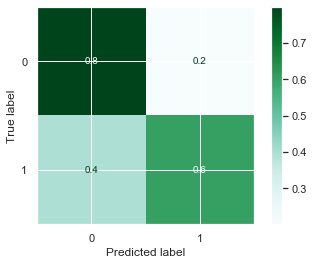

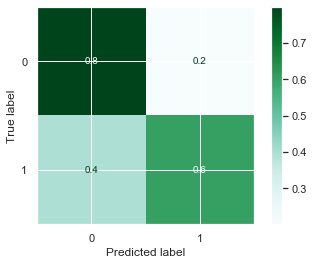

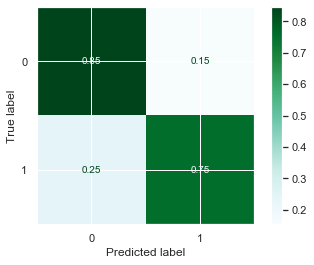

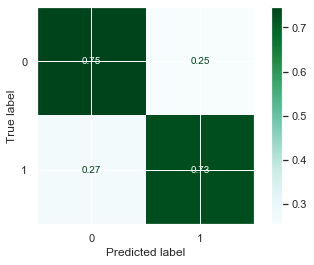

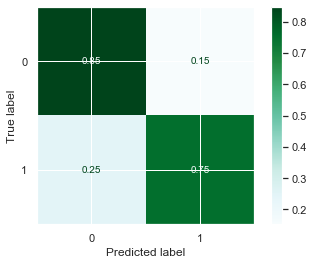

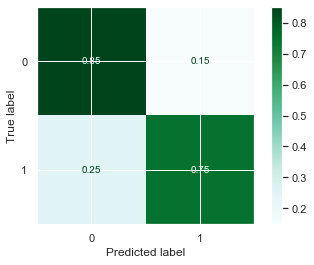

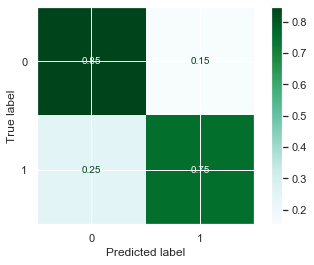

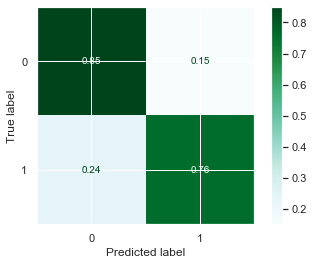

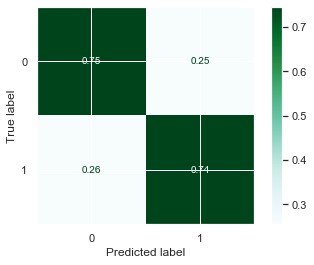

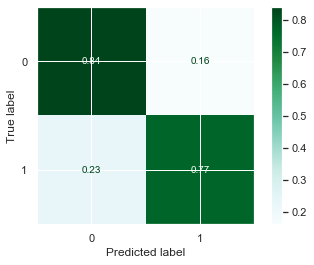

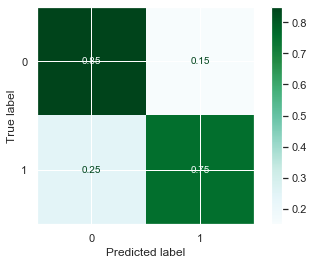

In [28]:
model_selector_nearmiss = ModelSelector(nearmiss_dataset)
df_2_ = model_selector_nearmiss.start(classifiers)
df_2_

## SMOTETomek

In [30]:
smote_tomek_dataset = split_data_set(
    pd.read_csv(SMOTE_TOMEK_DATASET_TRAIN),
    pd.read_csv(SMOTE_TOMEK_DATASET_TEST)
)

(101432, 43)
(27032, 43)


===================  START  ===================
START  LogisticRegression


C:\Users\domin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
NVMLError: NVML Shared Library Not Found - GPU usage metrics may not be reported.


https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-260
END  LogisticRegression
START  LogisticRegression


C:\Users\domin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-261
END  LogisticRegression
START  HistGradientBoostingClassifier


C:\Users\domin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-262
END  HistGradientBoostingClassifier
START  DecisionTreeClassifier
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-263
END  DecisionTreeClassifier
START  RandomForestClassifier


C:\Users\domin\Anaconda3\lib\site-packages\sklearn\pipeline.py:335: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
NVMLError: NVML Shared Library Not Found - GPU usage metrics may not be reported.


https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-264
END  RandomForestClassifier
START  AdaBoostClassifier


C:\Users\domin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-265
END  AdaBoostClassifier
START  GradientBoostingClassifier


C:\Users\domin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
NVMLError: NVML Shared Library Not Found - GPU usage metrics may not be reported.


https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-266
END  GradientBoostingClassifier
START  CatBoostClassifier
Learning rate set to 0.074058
0:	learn: 0.6580371	total: 28.2ms	remaining: 28.2s
1:	learn: 0.6250244	total: 52.2ms	remaining: 26.1s
2:	learn: 0.6003395	total: 73.1ms	remaining: 24.3s
3:	learn: 0.5467670	total: 99.5ms	remaining: 24.8s
4:	learn: 0.5112010	total: 123ms	remaining: 24.5s
5:	learn: 0.4965456	total: 143ms	remaining: 23.8s
6:	learn: 0.4852701	total: 165ms	remaining: 23.3s
7:	learn: 0.4591336	total: 198ms	remaining: 24.6s
8:	learn: 0.4497446	total: 219ms	remaining: 24.1s
9:	learn: 0.4232649	total: 243ms	remaining: 24.1s
10:	learn: 0.4176048	total: 272ms	remaining: 24.5s
11:	learn: 0.4121570	total: 291ms	remaining: 24s
12:	learn: 0.4074082	total: 313ms	remaining: 23.8s
13:	learn: 0.4012358	total: 334ms	remaining: 23.6s
14:	learn: 0.3891515	total: 356ms	remaining: 23.4s
15:	learn: 0.3855035	total: 391ms	remaining: 24s
16:	learn: 0.3815

NVMLError: NVML Shared Library Not Found - GPU usage metrics may not be reported.


https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-267
END  CatBoostClassifier
START  ExtraTreesClassifier


C:\Users\domin\Anaconda3\lib\site-packages\sklearn\pipeline.py:335: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-268
END  ExtraTreesClassifier
START  XGBClassifier


C:\Users\domin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
NVMLError: NVML Shared Library Not Found - GPU usage metrics may not be reported.


https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-269
END  XGBClassifier
START  LGBMClassifier


C:\Users\domin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-270
END  LGBMClassifier
===================  END  ===================


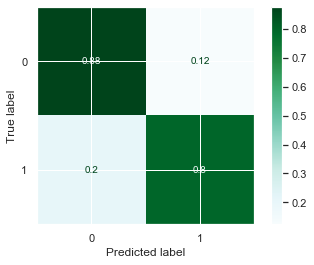

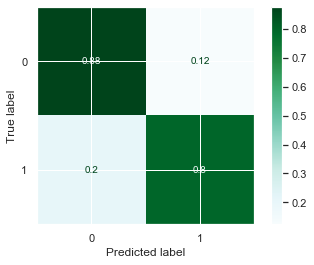

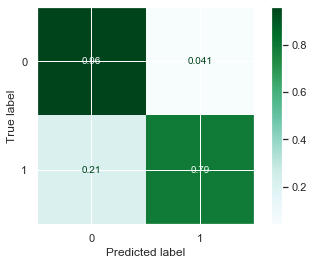

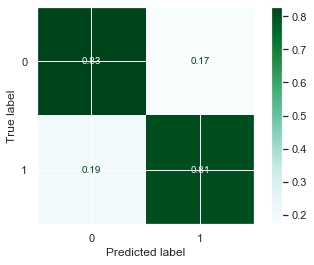

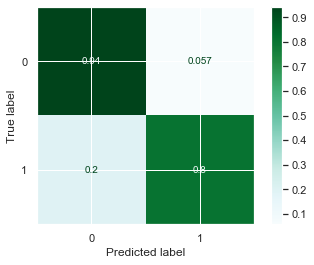

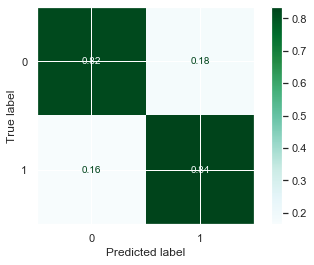

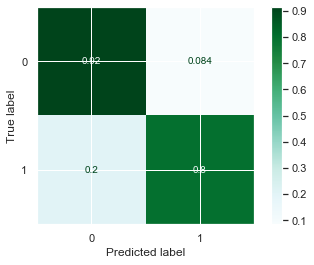

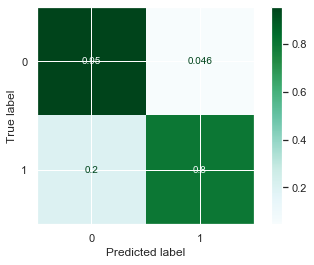

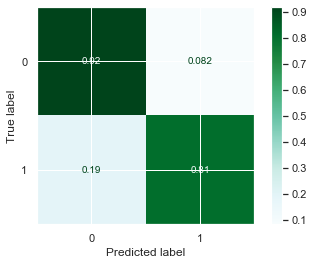

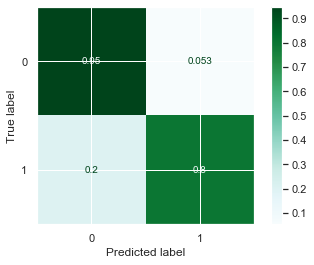

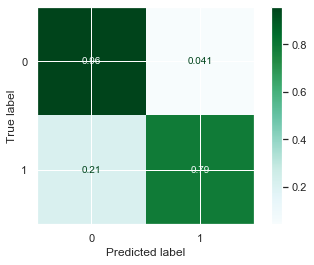

In [31]:
model_selector_smote_tomek = ModelSelector(smote_tomek_dataset)
df_3_ = model_selector_smote_tomek.start(classifiers)

In [32]:
df_3_

,name,train_score,test_score,accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
0,LogisticRegression,0.836452,0.835972,0.836,0.865,0.796,0.829,0.836
1,LogisticRegression,0.836452,0.835972,0.836,0.865,0.796,0.829,0.836
2,HistGradientBoostingClassifier,0.881901,0.873668,0.874,0.951,0.788,0.862,0.874
3,DecisionTreeClassifier,0.998097,0.818437,0.818,0.825,0.809,0.817,0.818
4,RandomForestClassifier,0.998068,0.873742,0.874,0.933,0.805,0.864,0.874
5,AdaBoostClassifier,0.829186,0.829868,0.830,0.826,0.835,0.831,0.830
6,GradientBoostingClassifier,0.860162,0.857095,0.857,0.905,0.798,0.848,0.857
7,CatBoostClassifier,0.500000,0.500000,0.876,0.945,0.798,0.865,0.876
8,ExtraTreesClassifier,0.998097,0.864272,0.864,0.909,0.810,0.856,0.864
9,XGBClassifier,0.904675,0.871967,0.872,0.938,0.797,0.862,0.872


## RAW

In [36]:
raw_dataset = split_data_set(
    pd.read_csv(RAW_DATASET_TRAIN),
    pd.read_csv(RAW_DATASET_TEST)
)

(77585, 43)
(21883, 43)


===================  START  ===================
START  LogisticRegression


C:\Users\domin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
NVMLError: NVML Shared Library Not Found - GPU usage metrics may not be reported.


https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-271
END  LogisticRegression
START  LogisticRegression


C:\Users\domin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-272
END  LogisticRegression
START  HistGradientBoostingClassifier


C:\Users\domin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-273
END  HistGradientBoostingClassifier
START  DecisionTreeClassifier
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-274
END  DecisionTreeClassifier
START  RandomForestClassifier


C:\Users\domin\Anaconda3\lib\site-packages\sklearn\pipeline.py:335: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
NVMLError: NVML Shared Library Not Found - GPU usage metrics may not be reported.


https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-275
END  RandomForestClassifier
START  AdaBoostClassifier


C:\Users\domin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-276
END  AdaBoostClassifier
START  GradientBoostingClassifier


C:\Users\domin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
NVMLError: NVML Shared Library Not Found - GPU usage metrics may not be reported.


https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-277
END  GradientBoostingClassifier
START  CatBoostClassifier
Learning rate set to 0.066049
0:	learn: 0.6537802	total: 44.4ms	remaining: 44.3s
1:	learn: 0.6211727	total: 69.5ms	remaining: 34.7s
2:	learn: 0.5934940	total: 87.4ms	remaining: 29s
3:	learn: 0.5708619	total: 116ms	remaining: 28.9s
4:	learn: 0.5539122	total: 144ms	remaining: 28.7s
5:	learn: 0.5395517	total: 162ms	remaining: 26.9s
6:	learn: 0.5265500	total: 189ms	remaining: 26.7s
7:	learn: 0.5166837	total: 217ms	remaining: 26.9s
8:	learn: 0.5088624	total: 246ms	remaining: 27.1s
9:	learn: 0.4994735	total: 265ms	remaining: 26.2s
10:	learn: 0.4914489	total: 283ms	remaining: 25.5s
11:	learn: 0.4846901	total: 304ms	remaining: 25.1s
12:	learn: 0.4808727	total: 322ms	remaining: 24.4s
13:	learn: 0.4762872	total: 339ms	remaining: 23.9s
14:	learn: 0.4718697	total: 362ms	remaining: 23.7s
15:	learn: 0.4693169	total: 379ms	remaining: 23.3s
16:	learn: 0.466

NVMLError: NVML Shared Library Not Found - GPU usage metrics may not be reported.


https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-278
END  CatBoostClassifier
START  ExtraTreesClassifier


C:\Users\domin\Anaconda3\lib\site-packages\sklearn\pipeline.py:335: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-279
END  ExtraTreesClassifier
START  XGBClassifier


C:\Users\domin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
NVMLError: NVML Shared Library Not Found - GPU usage metrics may not be reported.


https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-280
END  XGBClassifier
START  LGBMClassifier


C:\Users\domin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-281
END  LGBMClassifier
===================  END  ===================


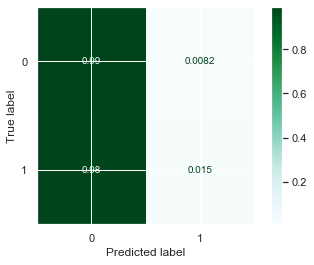

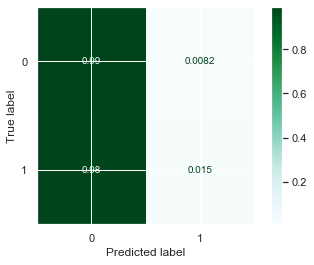

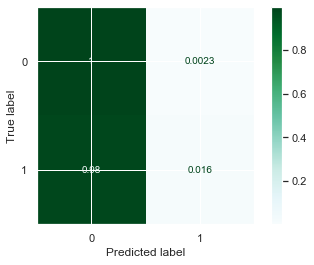

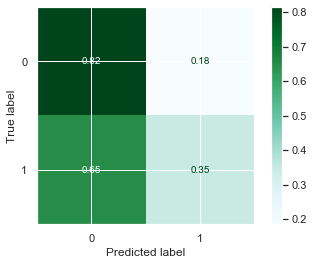

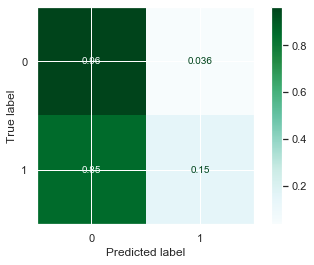

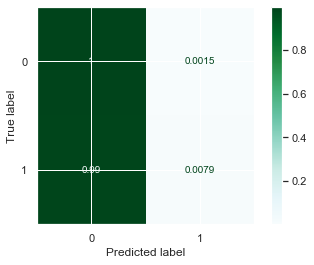

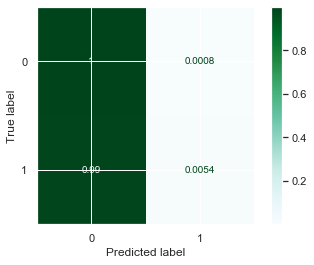

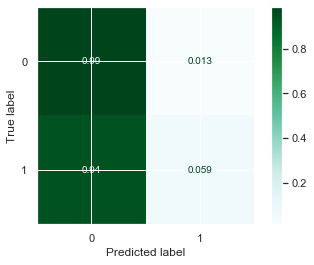

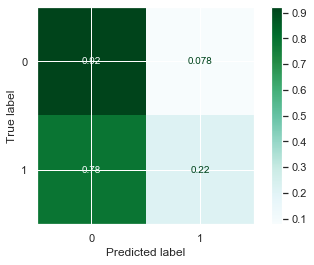

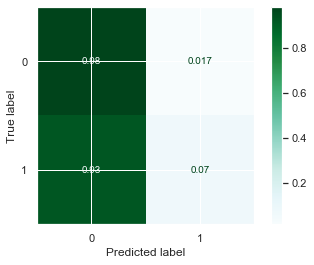

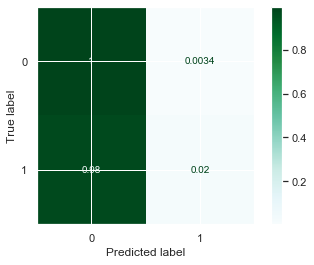

In [37]:
model_selector_raw_dataset = ModelSelector(raw_dataset)
df_4_ = model_selector_raw_dataset.start(classifiers)

## Summary

In [24]:
print('>> Adasyn <<')
df_

>> Adasyn <<


,name,train_score,test_score,accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
0,LogisticRegression,0.818538,0.820076,0.820,0.850,0.778,0.812,0.820
1,LogisticRegression,0.818538,0.820076,0.820,0.850,0.778,0.812,0.820
2,HistGradientBoostingClassifier,0.859695,0.857544,0.858,0.944,0.760,0.842,0.858
3,DecisionTreeClassifier,0.998436,0.803389,0.803,0.806,0.799,0.802,0.803
4,RandomForestClassifier,0.998403,0.859032,0.859,0.915,0.791,0.849,0.859
5,AdaBoostClassifier,0.812329,0.813836,0.814,0.811,0.819,0.815,0.814
6,GradientBoostingClassifier,0.840559,0.840942,0.841,0.887,0.781,0.831,0.841
7,CatBoostClassifier,0.500323,0.499982,0.860,0.937,0.773,0.847,0.860
8,ExtraTreesClassifier,0.998436,0.848899,0.849,0.887,0.799,0.841,0.849
9,XGBClassifier,0.879706,0.854080,0.854,0.922,0.773,0.841,0.854


In [17]:
print('>> Nearmiss <<')
df_2_

>> Nearmiss <<


,name,train_score,test_score,accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
0,LogisticRegression,0.702343,0.701335,0.701,0.750,0.604,0.669,0.701
1,LogisticRegression,0.702343,0.701335,0.701,0.750,0.604,0.669,0.701
2,HistGradientBoostingClassifier,0.812596,0.804663,0.805,0.839,0.755,0.794,0.805
3,DecisionTreeClassifier,0.996808,0.740493,0.740,0.741,0.740,0.740,0.740
4,RandomForestClassifier,0.996808,0.800249,0.800,0.836,0.747,0.789,0.800
5,AdaBoostClassifier,0.786102,0.799796,0.800,0.835,0.747,0.789,0.800
6,GradientBoostingClassifier,0.790379,0.799457,0.799,0.831,0.752,0.789,0.799
7,CatBoostClassifier,0.500000,0.500000,0.805,0.836,0.760,0.796,0.805
8,ExtraTreesClassifier,0.996808,0.743889,0.744,0.746,0.739,0.743,0.744
9,XGBClassifier,0.847006,0.804550,0.805,0.828,0.769,0.797,0.805


In [18]:
print('>> SMOTETomek <<')
df_3_

>> SMOTETomek <<


,name,train_score,test_score,accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
0,LogisticRegression,0.836452,0.835972,0.836,0.865,0.796,0.829,0.836
1,LogisticRegression,0.836452,0.835972,0.836,0.865,0.796,0.829,0.836
2,HistGradientBoostingClassifier,0.881250,0.873076,0.873,0.949,0.788,0.861,0.873
3,DecisionTreeClassifier,0.998097,0.819621,0.820,0.824,0.812,0.818,0.820
4,RandomForestClassifier,0.998078,0.875074,0.875,0.935,0.806,0.866,0.875
5,AdaBoostClassifier,0.829186,0.829868,0.830,0.826,0.835,0.831,0.830
6,GradientBoostingClassifier,0.860162,0.857095,0.857,0.905,0.798,0.848,0.857
7,CatBoostClassifier,0.500000,0.500000,0.876,0.945,0.798,0.865,0.876
8,ExtraTreesClassifier,0.998097,0.864346,0.864,0.909,0.810,0.857,0.864
9,XGBClassifier,0.904675,0.871967,0.872,0.938,0.797,0.862,0.872


In [19]:
print('>> Raw <<')
df_4_

>> Raw <<


,name,train_score,test_score,accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
0,LogisticRegression,0.795308,0.794635,0.795,0.319,0.015,0.029,0.503
1,LogisticRegression,0.795308,0.794635,0.795,0.319,0.015,0.029,0.503
2,HistGradientBoostingClassifier,0.802397,0.799982,0.800,0.661,0.019,0.037,0.508
3,DecisionTreeClassifier,0.997512,0.719691,0.720,0.320,0.345,0.332,0.580
4,RandomForestClassifier,0.997474,0.797240,0.797,0.492,0.139,0.217,0.552
5,AdaBoostClassifier,0.797938,0.798519,0.799,0.574,0.008,0.016,0.503
6,GradientBoostingClassifier,0.798544,0.798565,0.799,0.632,0.005,0.011,0.502
7,CatBoostClassifier,0.781606,0.784649,0.799,0.526,0.059,0.106,0.523
8,ExtraTreesClassifier,0.997512,0.781657,0.782,0.421,0.216,0.285,0.570
9,XGBClassifier,0.821035,0.798428,0.798,0.506,0.070,0.123,0.526
